# Binary classification using the Smart Home Intrusion Dataset on Kaggle
https://www.kaggle.com/datasets/bobaaayoung/dataset-invade

# Temporal Graph Network (TGN) implementation

In [ ]:
!git clone https://github.com/pyg-team/pytorch_geometric.git

Cloning into 'pytorch_geometric'...
remote: Enumerating objects: 74007, done.
remote: Counting objects: 100% (8230/8230), done.
remote: Compressing objects: 100% (791/791), done.
remote: Total 74007 (delta 7814), reused 7672 (delta 7437), pack-reused 65777
Receiving objects: 100% (74007/74007), 19.37 MiB | 17.09 MiB/s, done.
Resolving deltas: 100% (57527/57527), done.


In [ ]:
%cd pytorch_geometric

/content/pytorch_geometric


In [ ]:
import sys
sys.path.append('/content/pytorch_geometric/examples/tgn.py')

In [ ]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.2 MB/s eta 0:00:00


In [ ]:
#Import TGN model definitions
import sys
import importlib

# Append the correct path to the system path
sys.path.append('/content/pytorch_geometric/examples/')

# Reload the module to ensure it's using the updated path
import tgn
from tgn import TGNMemory, TransformerConv, IdentityMessage, LastNeighborLoader, LastAggregator

Processing...
Done!


Epoch: 01, Loss: 1.1329
Val AP: 0.8984, Val AUC: 0.9039
Test AP: 0.8825, Test AUC: 0.8903
Epoch: 02, Loss: 0.7561
Val AP: 0.9381, Val AUC: 0.9362
Test AP: 0.9326, Test AUC: 0.9303
Epoch: 03, Loss: 0.6827
Val AP: 0.9453, Val AUC: 0.9427
Test AP: 0.9430, Test AUC: 0.9402
Epoch: 04, Loss: 0.6525
Val AP: 0.9513, Val AUC: 0.9486
Test AP: 0.9470, Test AUC: 0.9437
Epoch: 05, Loss: 0.6255
Val AP: 0.9570, Val AUC: 0.9534
Test AP: 0.9528, Test AUC: 0.9488
Epoch: 06, Loss: 0.6062
Val AP: 0.9578, Val AUC: 0.9548
Test AP: 0.9518, Test AUC: 0.9477
Epoch: 07, Loss: 0.5870
Val AP: 0.9600, Val AUC: 0.9564
Test AP: 0.9551, Test AUC: 0.9513
Epoch: 08, Loss: 0.5836
Val AP: 0.9598, Val AUC: 0.9558
Test AP: 0.9536, Test AUC: 0.9496
Epoch: 09, Loss: 0.5748
Val AP: 0.9614, Val AUC: 0.9577
Test AP: 0.9577, Test AUC: 0.9537
Epoch: 10, Loss: 0.5634
Val AP: 0.9616, Val AUC: 0.9580
Test AP: 0.9565, Test AUC: 0.9528
Epoch: 11, Loss: 0.5571
Val AP: 0.9623, Val AUC: 0.9584
Test AP: 0.9572, Test AUC: 0.9535
Epoch: 12,

In [ ]:
# Base TGN Model from the torch-geometric TGN model with Jodie Dataset other models are based
import os.path as osp

import torch
from sklearn.metrics import average_precision_score, roc_auc_score
from torch.nn import Linear

from torch_geometric.datasets import JODIEDataset
from torch_geometric.loader import TemporalDataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

path = 'data/JODIE'  # Adjusted path for Colab
dataset = JODIEDataset(path, name='wikipedia')
data = dataset[0]

# For small datasets, we can put the whole dataset on GPU and thus avoid
# expensive memory transfer costs for mini-batches:
data = data.to(device)

train_data, val_data, test_data = data.train_val_test_split(
    val_ratio=0.15, test_ratio=0.15)

train_loader = TemporalDataLoader(
    train_data,
    batch_size=200,
    neg_sampling_ratio=1.0,
)
val_loader = TemporalDataLoader(
    val_data,
    batch_size=200,
    neg_sampling_ratio=1.0,
)
test_loader = TemporalDataLoader(
    test_data,
    batch_size=200,
    neg_sampling_ratio=1.0,
)
neighbor_loader = LastNeighborLoader(data.num_nodes, size=10, device=device)


class GraphAttentionEmbedding(torch.nn.Module):
    def __init__(self, in_channels, out_channels, msg_dim, time_enc):
        super().__init__()
        self.time_enc = time_enc
        edge_dim = msg_dim + time_enc.out_channels
        self.conv = TransformerConv(in_channels, out_channels // 2, heads=2,
                                    dropout=0.1, edge_dim=edge_dim)

    def forward(self, x, last_update, edge_index, t, msg):
        rel_t = last_update[edge_index[0]] - t
        rel_t_enc = self.time_enc(rel_t.to(x.dtype))
        edge_attr = torch.cat([rel_t_enc, msg], dim=-1)
        return self.conv(x, edge_index, edge_attr)


class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.lin_src = Linear(in_channels, in_channels)
        self.lin_dst = Linear(in_channels, in_channels)
        self.lin_final = Linear(in_channels, 1)

    def forward(self, z_src, z_dst):
        h = self.lin_src(z_src) + self.lin_dst(z_dst)
        h = h.relu()
        return self.lin_final(h)


memory_dim = time_dim = embedding_dim = 100

memory = TGNMemory(
    data.num_nodes,
    data.msg.size(-1),
    memory_dim,
    time_dim,
    message_module=IdentityMessage(data.msg.size(-1), memory_dim, time_dim),
    aggregator_module=LastAggregator(),
).to(device)

gnn = GraphAttentionEmbedding(
    in_channels=memory_dim,
    out_channels=embedding_dim,
    msg_dim=data.msg.size(-1),
    time_enc=memory.time_enc,
).to(device)

link_pred = LinkPredictor(in_channels=embedding_dim).to(device)

optimizer = torch.optim.Adam(
    set(memory.parameters()) | set(gnn.parameters())
    | set(link_pred.parameters()), lr=0.0001)
criterion = torch.nn.BCEWithLogitsLoss()

# Helper vector to map global node indices to local ones.
assoc = torch.empty(data.num_nodes, dtype=torch.long, device=device)


def train():
    memory.train()
    gnn.train()
    link_pred.train()

    memory.reset_state()  # Start with a fresh memory.
    neighbor_loader.reset_state()  # Start with an empty graph.

    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)

        n_id, edge_index, e_id = neighbor_loader(batch.n_id)
        assoc[n_id] = torch.arange(n_id.size(0), device=device)

        # Get updated memory of all nodes involved in the computation.
        z, last_update = memory(n_id)
        z = gnn(z, last_update, edge_index, data.t[e_id].to(device),
                data.msg[e_id].to(device))
        pos_out = link_pred(z[assoc[batch.src]], z[assoc[batch.dst]])
        neg_out = link_pred(z[assoc[batch.src]], z[assoc[batch.neg_dst]])

        loss = criterion(pos_out, torch.ones_like(pos_out))
        loss += criterion(neg_out, torch.zeros_like(neg_out))

        # Update memory and neighbor loader with ground-truth state.
        memory.update_state(batch.src, batch.dst, batch.t, batch.msg)
        neighbor_loader.insert(batch.src, batch.dst)

        loss.backward()
        optimizer.step()
        memory.detach()
        total_loss += float(loss) * batch.num_events

    return total_loss / train_data.num_events


@torch.no_grad()
def test(loader):
    memory.eval()
    gnn.eval()
    link_pred.eval()

    torch.manual_seed(12345)  # Ensure deterministic sampling across epochs.

    aps, aucs = [], []
    for batch in loader:
        batch = batch.to(device)

        n_id, edge_index, e_id = neighbor_loader(batch.n_id)
        assoc[n_id] = torch.arange(n_id.size(0), device=device)

        z, last_update = memory(n_id)
        z = gnn(z, last_update, edge_index, data.t[e_id].to(device),
                data.msg[e_id].to(device))
        pos_out = link_pred(z[assoc[batch.src]], z[assoc[batch.dst]])
        neg_out = link_pred(z[assoc[batch.src]], z[assoc[batch.neg_dst]])

        y_pred = torch.cat([pos_out, neg_out], dim=0).sigmoid().cpu()
        y_true = torch.cat(
            [torch.ones(pos_out.size(0)),
             torch.zeros(neg_out.size(0))], dim=0)

        aps.append(average_precision_score(y_true, y_pred))
        aucs.append(roc_auc_score(y_true, y_pred))

        memory.update_state(batch.src, batch.dst, batch.t, batch.msg)
        neighbor_loader.insert(batch.src, batch.dst)
    return float(torch.tensor(aps).mean()), float(torch.tensor(aucs).mean())


for epoch in range(1, 51):
    loss = train()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')
    val_ap, val_auc = test(val_loader)
    test_ap, test_auc = test(test_loader)
    print(f'Val AP: {val_ap:.4f}, Val AUC: {val_auc:.4f}')
    print(f'Test AP: {test_ap:.4f}, Test AUC: {test_auc:.4f}')

Epoch: 01, Loss: 1.1439
Val AP: 0.8549, Val AUC: 0.8717
Test AP: 0.8216, Test AUC: 0.8478
Epoch: 02, Loss: 0.9111
Val AP: 0.9227, Val AUC: 0.9193
Test AP: 0.9161, Test AUC: 0.9124
Epoch: 03, Loss: 0.7239
Val AP: 0.9386, Val AUC: 0.9341
Test AP: 0.9243, Test AUC: 0.9194
Epoch: 04, Loss: 0.6636
Val AP: 0.9487, Val AUC: 0.9429
Test AP: 0.9346, Test AUC: 0.9278
Epoch: 05, Loss: 0.6549
Val AP: 0.9484, Val AUC: 0.9439
Test AP: 0.9432, Test AUC: 0.9380
Epoch: 06, Loss: 0.6223
Val AP: 0.9545, Val AUC: 0.9507
Test AP: 0.9528, Test AUC: 0.9479
Epoch: 07, Loss: 0.6109
Val AP: 0.9560, Val AUC: 0.9529
Test AP: 0.9510, Test AUC: 0.9476
Epoch: 08, Loss: 0.5945
Val AP: 0.9596, Val AUC: 0.9558
Test AP: 0.9540, Test AUC: 0.9498
Epoch: 09, Loss: 0.5847
Val AP: 0.9609, Val AUC: 0.9571
Test AP: 0.9542, Test AUC: 0.9494
Epoch: 10, Loss: 0.5705
Val AP: 0.9634, Val AUC: 0.9591
Test AP: 0.9602, Test AUC: 0.9561
Epoch: 11, Loss: 0.5582
Val AP: 0.9643, Val AUC: 0.9594
Test AP: 0.9594, Test AUC: 0.9540
Epoch: 12,

In [ ]:
import pandas as pd

# Load the dataset
data_path = '/content/dataset_invade.csv'
data = pd.read_csv(data_path)

# Display the first few rows of the dataset
print(data.head())


   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  serror_rate  rerror_rate  same_srv_rate  \
0               0       0    0  ...          0.0          0.0           1.00   
1               0       0    0  ...          0.0          0.0           0.08   
2               0       0    0  ...          1.0          0.0           0.05   
3               0       0    0  ...          0.2          0.0           1.00   
4               0       0    0  ...          0.0          0.0           1.00   

   diff_srv_rate  srv_diff_host_rate  dst_host_count  dst_host_srv_count  \
0         

In [ ]:
# Define features and target
features = data.drop(columns=['attack'])
target = data['attack']

# Encode the target variable
target = target.apply(lambda x: 1 if x == 'Yes' else 0)

# Display the features and target to ensure they are correctly separated
print(features.head())
print(target.head())


   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  srv_count  serror_rate  rerror_rate  \
0               0       0    0  ...          2          0.0          0.0   
1               0       0    0  ...          1          0.0          0.0   
2               0       0    0  ...          6          1.0          0.0   
3               0       0    0  ...          5          0.2          0.0   
4               0       0    0  ...         32          0.0          0.0   

   same_srv_rate  diff_srv_rate  srv_diff_host_rate  dst_host_count  \
0           1.00           0.00        

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into train and temporary data (temp_data)
train_data, temp_data, train_labels, temp_labels = train_test_split(
    features, target, test_size=0.3, random_state=42)

# Further split the temporary data into validation and test data
val_data, test_data, val_labels, test_labels = train_test_split(
    temp_data, temp_labels, test_size=0.5, random_state=42)

# Display the shapes of the splits to ensure correctness
print(f"Train data shape: {train_data.shape}, Train labels shape: {train_labels.shape}")
print(f"Validation data shape: {val_data.shape}, Validation labels shape: {val_labels.shape}")
print(f"Test data shape: {test_data.shape}, Test labels shape: {test_labels.shape}")


Train data shape: (103961, 23), Train labels shape: (103961,)
Validation data shape: (22278, 23), Validation labels shape: (22278,)
Test data shape: (22278, 23), Test labels shape: (22278,)


In [ ]:
import pandas as pd
import torch

# Load the dataset
data_path = '/content/dataset_invade.csv'
data = pd.read_csv(data_path)

# Define features and target
features = data.drop(columns=['attack'])
target = data['attack']

# Encode the target variable
target = target.apply(lambda x: 1 if x == 'Yes' else 0)

# Identify non-numeric columns
non_numeric_columns = features.select_dtypes(include=['object', 'bool']).columns
print("Non-numeric columns:", non_numeric_columns)

# Convert categorical columns to one-hot encoded columns
features = pd.get_dummies(features, columns=non_numeric_columns)

# Convert boolean columns to integers
for col in features.select_dtypes(include=['bool']).columns:
    features[col] = features[col].astype(int)

# Ensure all columns are now numeric
print(features.dtypes)

# Convert to PyTorch tensors
X_tensor = torch.tensor(features.values, dtype=torch.float32)
y_tensor = torch.tensor(target.values, dtype=torch.float32)

# Display the shapes of the tensors
print(X_tensor.shape, y_tensor.shape)


Non-numeric columns: Index(['protocol_type', 'service', 'flag'], dtype='object')
duration          int64
src_bytes         int64
dst_bytes         int64
land              int64
wrong_fragment    int64
                  ...  
flag_S1           int64
flag_S2           int64
flag_S3           int64
flag_SF           int64
flag_SH           int64
Length: 104, dtype: object
torch.Size([148517, 104]) torch.Size([148517])


# Pivoted to FeedForward Neural Network (FNN) due to memory issues with TGN

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess data
data_path = '/content/dataset_invade.csv'
data = pd.read_csv(data_path)
features = data.drop(columns=['attack'])
target = data['attack'].apply(lambda x: 1 if x == 'Yes' else 0)

# Convert categorical columns to one-hot encoded columns
non_numeric_columns = features.select_dtypes(include=['object']).columns
features = pd.get_dummies(features, columns=non_numeric_columns)

# Convert boolean columns to integers
for col in features.select_dtypes(include=['bool']).columns:
    features[col] = features[col].astype(int)

# Ensure all columns are now numeric
print(features.dtypes)

# Convert to PyTorch tensors
X_tensor = torch.tensor(features.values, dtype=torch.float32)
y_tensor = torch.tensor(target.values, dtype=torch.float32)

# Display the shapes of the tensors
print(X_tensor.shape, y_tensor.shape)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create DataLoader for each dataset
batch_size = 64

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the model, loss function, and optimizer
class SimpleNN(torch.nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

input_dim = X_tensor.shape[1]
model = SimpleNN(input_dim)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(loader):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(loader.dataset)

# Evaluation function
def evaluate_model(loader):
    model.eval()
    running_loss = 0.0
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            running_loss += loss.item() * inputs.size(0)
            all_outputs.append(outputs.squeeze().cpu())
            all_labels.append(labels.cpu())
    return running_loss / len(loader.dataset), torch.cat(all_outputs), torch.cat(all_labels)

# Training loop
num_epochs = 51
for epoch in range(num_epochs):
    train_loss = train_model(train_loader)
    val_loss, val_outputs, val_labels = evaluate_model(val_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Test the model
test_loss, test_outputs, test_labels = evaluate_model(test_loader)
print(f'Test Loss: {test_loss:.4f}')

# Calculate test metrics
test_outputs = (test_outputs > 0.5).float()
accuracy = (test_outputs == test_labels).float().mean()
print(f'Test Accuracy: {accuracy:.4f}')


duration          int64
src_bytes         int64
dst_bytes         int64
land              int64
wrong_fragment    int64
                  ...  
flag_S1           int64
flag_S2           int64
flag_S3           int64
flag_SF           int64
flag_SH           int64
Length: 104, dtype: object
torch.Size([148517, 104]) torch.Size([148517])
Epoch 1/51, Train Loss: 3.5453, Val Loss: 3.5810
Epoch 2/51, Train Loss: 2.5663, Val Loss: 2.7189
Epoch 3/51, Train Loss: 1.7442, Val Loss: 0.7902
Epoch 4/51, Train Loss: 1.7059, Val Loss: 1.5057
Epoch 5/51, Train Loss: 1.3192, Val Loss: 1.5550
Epoch 6/51, Train Loss: 1.5199, Val Loss: 1.7100
Epoch 7/51, Train Loss: 0.9759, Val Loss: 1.5850
Epoch 8/51, Train Loss: 1.2220, Val Loss: 0.5963
Epoch 9/51, Train Loss: 1.0870, Val Loss: 1.5884
Epoch 10/51, Train Loss: 1.1355, Val Loss: 0.9824
Epoch 11/51, Train Loss: 0.6744, Val Loss: 0.4340
Epoch 12/51, Train Loss: 0.8867, Val Loss: 1.4495
Epoch 13/51, Train Loss: 1.0902, Val Loss: 0.6165
Epoch 14/51, Train Lo

In [ ]:
import os.path as osp
import torch
from sklearn.metrics import average_precision_score, roc_auc_score
from torch.nn import Linear
import pandas as pd
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import TGNMemory, TransformerConv
from torch_geometric.nn.models.tgn import IdentityMessage, LastAggregator, LastNeighborLoader
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the dataset
data_path = '/content/dataset_invade.csv'
data = pd.read_csv(data_path)

# Define features and target
features = data.drop(columns=['attack'])
target = data['attack']

# Encode the target variable
target = target.apply(lambda x: 1 if x == 'Yes' else 0)

# Identify non-numeric columns
non_numeric_columns = features.select_dtypes(include=['object', 'bool']).columns

# Convert categorical columns to one-hot encoded columns
features = pd.get_dummies(features, columns=non_numeric_columns)

# Convert boolean columns to integers
for col in features.select_dtypes(include=['bool']).columns:
    features[col] = features[col].astype(int)

# Ensure all columns are now numeric
print(features.dtypes)

# Convert to PyTorch tensors
X_tensor = torch.tensor(features.values, dtype=torch.float32)
y_tensor = torch.tensor(target.values, dtype=torch.float32)

# Split the data into train, validation, and test sets
train_data, temp_data, train_labels, temp_labels = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)
val_data, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.5, random_state=42)

# Create PyTorch Geometric Data objects
def create_graph_data(features, labels):
    num_nodes = features.shape[0]
    edge_index = torch.combinations(torch.arange(num_nodes), r=2).T  # Fully connected graph
    data = Data(x=features, edge_index=edge_index, y=labels)
    return data

train_graph = create_graph_data(train_data, train_labels)
val_graph = create_graph_data(val_data, val_labels)
test_graph = create_graph_data(test_data, test_labels)

train_loader = DataLoader([train_graph], batch_size=50, shuffle=True)
val_loader = DataLoader([val_graph], batch_size=50, shuffle=False)
test_loader = DataLoader([test_graph], batch_size=50, shuffle=False)

# TGN Model Definition
class GraphAttentionEmbedding(torch.nn.Module):
    def __init__(self, in_channels, out_channels, msg_dim, time_enc):
        super().__init__()
        self.time_enc = time_enc
        edge_dim = msg_dim + time_enc.out_channels
        self.conv = TransformerConv(in_channels, out_channels // 2, heads=2, dropout=0.1, edge_dim=edge_dim)

    def forward(self, x, last_update, edge_index, t, msg):
        rel_t = last_update[edge_index[0]] - t
        rel_t_enc = self.time_enc(rel_t.to(x.dtype))
        edge_attr = torch.cat([rel_t_enc, msg], dim=-1)
        return self.conv(x, edge_index, edge_attr)

class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.lin_src = Linear(in_channels, in_channels)
        self.lin_dst = Linear(in_channels, in_channels)
        self.lin_final = Linear(in_channels, 1)

    def forward(self, z_src, z_dst):
        h = self.lin_src(z_src) + self.lin_dst(z_dst)
        h = h.relu()
        return self.lin_final(h)

memory_dim = time_dim = embedding_dim = 100

memory = TGNMemory(
    train_graph.num_nodes,
    train_graph.num_nodes,
    memory_dim,
    time_dim,
    message_module=IdentityMessage(train_graph.num_nodes, memory_dim, time_dim),
    aggregator_module=LastAggregator(),
).to(device)

gnn = GraphAttentionEmbedding(
    in_channels=memory_dim,
    out_channels=embedding_dim,
    msg_dim=train_graph.num_nodes,
    time_enc=memory.time_enc,
).to(device)

link_pred = LinkPredictor(in_channels=embedding_dim).to(device)

optimizer = torch.optim.Adam(
    set(memory.parameters()) | set(gnn.parameters())
    | set(link_pred.parameters()), lr=0.0001)
criterion = torch.nn.BCEWithLogitsLoss()

# Training and Testing Routines
def train():
    memory.train()
    gnn.train()
    link_pred.train()

    memory.reset_state()

    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)

        n_id, edge_index, e_id = neighbor_loader(batch.n_id)
        assoc[n_id] = torch.arange(n_id.size(0), device=device)

        z, last_update = memory(n_id)
        z = gnn(z, last_update, edge_index, batch.t[e_id].to(device), batch.msg[e_id].to(device))
        pos_out = link_pred(z[assoc[batch.src]], z[assoc[batch.dst]])
        neg_out = link_pred(z[assoc[batch.src]], z[assoc[batch.neg_dst]])

        loss = criterion(pos_out, torch.ones_like(pos_out))
        loss += criterion(neg_out, torch.zeros_like(neg_out))

        memory.update_state(batch.src, batch.dst, batch.t, batch.msg)
        neighbor_loader.insert(batch.src, batch.dst)

        loss.backward()
        optimizer.step()
        memory.detach()
        total_loss += float(loss) * batch.num_events

    return total_loss / train_graph.num_nodes

@torch.no_grad()
def test(loader):
    memory.eval()
    gnn.eval()
    link_pred.eval()

    torch.manual_seed(12345)

    aps, aucs = []
    for batch in loader:
        batch = batch.to(device)

        n_id, edge_index, e_id = neighbor_loader(batch.n_id)
        assoc[n_id] = torch.arange(n_id.size(0), device=device)

        z, last_update = memory(n_id)
        z = gnn(z, last_update, edge_index, batch.t[e_id].to(device), batch.msg[e_id].to(device))
        pos_out = link_pred(z[assoc[batch.src]], z[assoc[batch.dst]])
        neg_out = link_pred(z[assoc[batch.src]], z[assoc[batch.neg_dst]])

        y_pred = torch.cat([pos_out, neg_out], dim=0).sigmoid().cpu()
        y_true = torch.cat([torch.ones(pos_out.size(0)), torch.zeros(neg_out.size(0))], dim=0)

        aps.append(average_precision_score(y_true, y_pred))
        aucs.append(roc_auc_score(y_true, y_pred))

        memory.update_state(batch.src, batch.dst, batch.t, batch.msg)
        neighbor_loader.insert(batch.src, batch.dst)

    return float(torch.tensor(aps).mean()), float(torch.tensor(aucs).mean())

for epoch in range(1, 25):
    loss = train()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')
    val_ap, val_auc = test(val_loader)
    test_ap, test_auc = test(test_loader)
    print(f'Val AP: {val_ap:.4f}, Val AUC: {val_auc:.4f}')
    print(f'Test AP: {test_ap:.4f}, Test AUC: {test_auc:.4f}')

duration          int64
src_bytes         int64
dst_bytes         int64
land              int64
wrong_fragment    int64
                  ...  
flag_S1           int64
flag_S2           int64
flag_S3           int64
flag_SF           int64
flag_SH           int64
Length: 104, dtype: object


# FNN model implementation

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import average_precision_score, roc_auc_score

# Load and preprocess data
data_path = '/content/dataset_invade.csv'
data = pd.read_csv(data_path)
features = data.drop(columns=['attack'])
target = data['attack'].apply(lambda x: 1 if x == 'Yes' else 0)

# Convert categorical columns to one-hot encoded columns
non_numeric_columns = features.select_dtypes(include=['object']).columns
features = pd.get_dummies(features, columns=non_numeric_columns)

# Convert boolean columns to integers
for col in features.select_dtypes(include=['bool']).columns:
    features[col] = features[col].astype(int)

# Ensure all columns are now numeric
print(features.dtypes)

# Convert to PyTorch tensors
X_tensor = torch.tensor(features.values, dtype=torch.float32)
y_tensor = torch.tensor(target.values, dtype=torch.float32)

# Display the shapes of the tensors
print(X_tensor.shape, y_tensor.shape)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create DataLoader for each dataset
batch_size = 64

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Simple Neural Network, loss function, and optimizer
class SimpleNN(torch.nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

input_dim = X_tensor.shape[1]
model = SimpleNN(input_dim)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(loader):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(loader.dataset)

# Evaluation function
def evaluate_model(loader):
    model.eval()
    running_loss = 0.0
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            running_loss += loss.item() * inputs.size(0)
            all_outputs.append(outputs.squeeze().cpu())
            all_labels.append(labels.cpu())
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)
    return running_loss / len(loader.dataset), all_outputs, all_labels

# Training loop
num_epochs = 25
for epoch in range(1, num_epochs+1):
    train_loss = train_model(train_loader)
    val_loss, val_outputs, val_labels = evaluate_model(val_loader)
    test_loss, test_outputs, test_labels = evaluate_model(test_loader)

    val_ap = average_precision_score(val_labels, val_outputs)
    val_auc = roc_auc_score(val_labels, val_outputs)
    test_ap = average_precision_score(test_labels, test_outputs)
    test_auc = roc_auc_score(test_labels, test_outputs)

    print(f'Epoch: {epoch:02d}, Loss: {train_loss:.4f}')
    print(f'Val AP: {val_ap:.4f}, Val AUC: {val_auc:.4f}')
    print(f'Test AP: {test_ap:.4f}, Test AUC: {test_auc:.4f}')

duration          int64
src_bytes         int64
dst_bytes         int64
land              int64
wrong_fragment    int64
                  ...  
flag_S1           int64
flag_S2           int64
flag_S3           int64
flag_SF           int64
flag_SH           int64
Length: 104, dtype: object
torch.Size([148517, 104]) torch.Size([148517])
Epoch: 01, Loss: 2.8516
Val AP: 0.8219, Val AUC: 0.9304
Test AP: 0.8230, Test AUC: 0.9311
Epoch: 02, Loss: 2.0385
Val AP: 0.9295, Val AUC: 0.9540
Test AP: 0.9282, Test AUC: 0.9551
Epoch: 03, Loss: 1.0373
Val AP: 0.9777, Val AUC: 0.9638
Test AP: 0.9747, Test AUC: 0.9630
Epoch: 04, Loss: 1.0972
Val AP: 0.9611, Val AUC: 0.9605
Test AP: 0.9549, Test AUC: 0.9593
Epoch: 05, Loss: 0.9841
Val AP: 0.8944, Val AUC: 0.9626
Test AP: 0.8967, Test AUC: 0.9628
Epoch: 06, Loss: 0.8193
Val AP: 0.9792, Val AUC: 0.9663
Test AP: 0.9789, Test AUC: 0.9660
Epoch: 07, Loss: 0.9300
Val AP: 0.9779, Val AUC: 0.9625
Test AP: 0.9773, Test AUC: 0.9619
Epoch: 08, Loss: 0.9327
Val AP: 

duration          int64
src_bytes         int64
dst_bytes         int64
land              int64
wrong_fragment    int64
                  ...  
flag_S1           int64
flag_S2           int64
flag_S3           int64
flag_SF           int64
flag_SH           int64
Length: 104, dtype: object
torch.Size([148517, 104]) torch.Size([148517])
Epoch: 01, Loss: 2.9910
Val AP: 0.9536, Val AUC: 0.9554
Test AP: 0.9463, Test AUC: 0.9536
Epoch: 02, Loss: 2.9616
Val AP: 0.9633, Val AUC: 0.9421
Test AP: 0.9634, Test AUC: 0.9427
Epoch: 03, Loss: 3.0475
Val AP: 0.8529, Val AUC: 0.9336
Test AP: 0.8485, Test AUC: 0.9314
Epoch: 04, Loss: 2.9443
Val AP: 0.9693, Val AUC: 0.9518
Test AP: 0.9693, Test AUC: 0.9513
Epoch: 05, Loss: 3.0379
Val AP: 0.9640, Val AUC: 0.9392
Test AP: 0.9641, Test AUC: 0.9394
Epoch: 06, Loss: 2.7936
Val AP: 0.8784, Val AUC: 0.9580
Test AP: 0.8788, Test AUC: 0.9586
Epoch: 07, Loss: 2.2160
Val AP: 0.8838, Val AUC: 0.9606
Test AP: 0.8811, Test AUC: 0.9605
Epoch: 08, Loss: 2.3758
Val AP: 

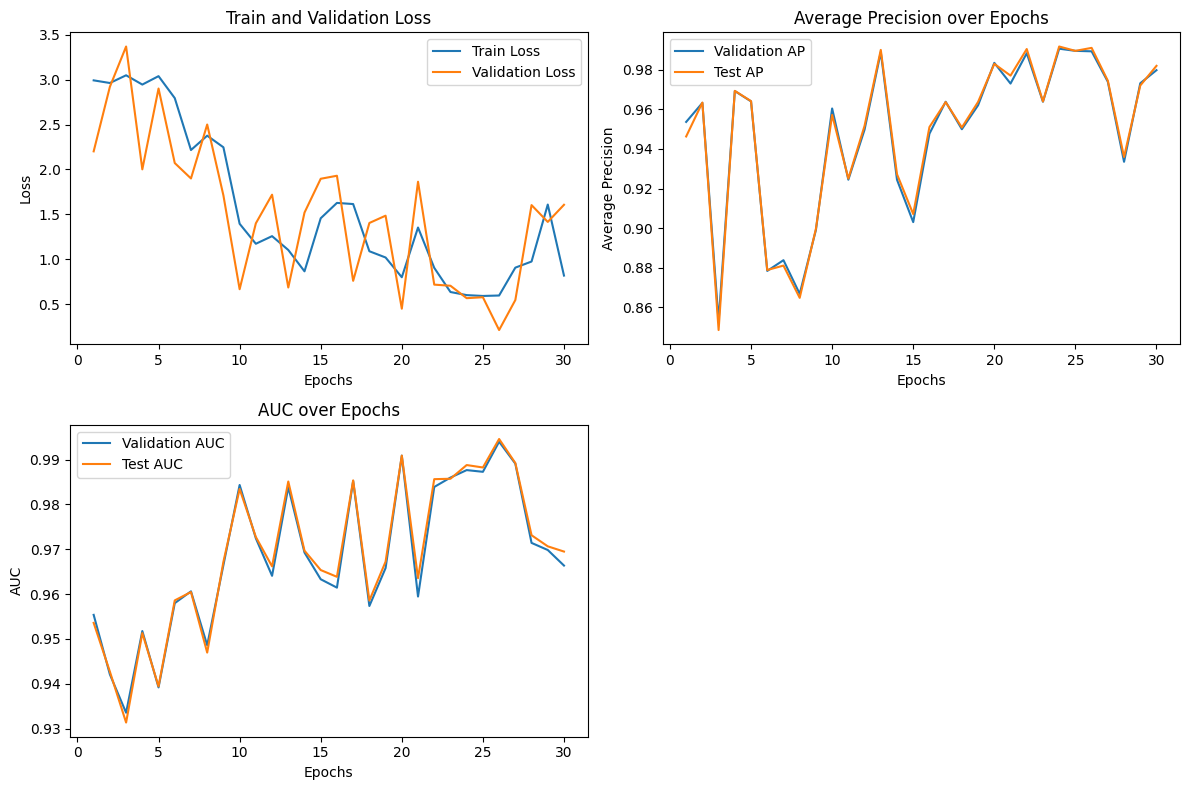

In [ ]:
#Added graphing and increased epochs from 25 to 30 from previous implementation
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import average_precision_score, roc_auc_score
import matplotlib.pyplot as plt

# Load and preprocess data
data_path = '/content/dataset_invade.csv'
data = pd.read_csv(data_path)
features = data.drop(columns=['attack'])
target = data['attack'].apply(lambda x: 1 if x == 'Yes' else 0)

# Convert categorical columns to one-hot encoded columns
non_numeric_columns = features.select_dtypes(include=['object']).columns
features = pd.get_dummies(features, columns=non_numeric_columns)

# Convert boolean columns to integers
for col in features.select_dtypes(include=['bool']).columns:
    features[col] = features[col].astype(int)

# Ensure all columns are now numeric
print(features.dtypes)

# Convert to PyTorch tensors
X_tensor = torch.tensor(features.values, dtype=torch.float32)
y_tensor = torch.tensor(target.values, dtype=torch.float32)

# Display the shapes of the tensors
print(X_tensor.shape, y_tensor.shape)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create DataLoader for each dataset
batch_size = 64

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the model, loss function, and optimizer
class SimpleNN(torch.nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

input_dim = X_tensor.shape[1]
model = SimpleNN(input_dim)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(loader):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(loader.dataset)

# Evaluation function
def evaluate_model(loader):
    model.eval()
    running_loss = 0.0
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            running_loss += loss.item() * inputs.size(0)
            all_outputs.append(outputs.squeeze().cpu())
            all_labels.append(labels.cpu())
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)
    return running_loss / len(loader.dataset), all_outputs, all_labels

# Training loop
num_epochs = 30
train_losses = []
val_losses = []
val_aps = []
val_aucs = []
test_aps = []
test_aucs = []

for epoch in range(1, num_epochs+1):
    train_loss = train_model(train_loader)
    val_loss, val_outputs, val_labels = evaluate_model(val_loader)
    test_loss, test_outputs, test_labels = evaluate_model(test_loader)

    val_ap = average_precision_score(val_labels, val_outputs)
    val_auc = roc_auc_score(val_labels, val_outputs)
    test_ap = average_precision_score(test_labels, test_outputs)
    test_auc = roc_auc_score(test_labels, test_outputs)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_aps.append(val_ap)
    val_aucs.append(val_auc)
    test_aps.append(test_ap)
    test_aucs.append(test_auc)

    print(f'Epoch: {epoch:02d}, Loss: {train_loss:.4f}')
    print(f'Val AP: {val_ap:.4f}, Val AUC: {val_auc:.4f}')
    print(f'Test AP: {test_ap:.4f}, Test AUC: {test_auc:.4f}')

# Plotting the results
epochs = range(1, num_epochs+1)
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')

plt.subplot(2, 2, 2)
plt.plot(epochs, val_aps, label='Validation AP')
plt.plot(epochs, test_aps, label='Test AP')
plt.xlabel('Epochs')
plt.ylabel('Average Precision')
plt.legend()
plt.title('Average Precision over Epochs')

plt.subplot(2, 2, 3)
plt.plot(epochs, val_aucs, label='Validation AUC')
plt.plot(epochs, test_aucs, label='Test AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.title('AUC over Epochs')

plt.tight_layout()
plt.show()


In [ ]:
#Iterative implementation to use entire dataset split into chunks, splits dataset into 5 chunks
import pandas as pd
import torch

# Load your full dataset
data_path = '/content/dataset_invade.csv'
data = pd.read_csv(data_path)
features = data.drop(columns=['attack'])
target = data['attack'].apply(lambda x: 1 if x == 'Yes' else 0)

# Convert categorical columns to one-hot encoded columns
non_numeric_columns = features.select_dtypes(include=['object']).columns
features = pd.get_dummies(features, columns=non_numeric_columns)

# Convert boolean columns to integers
for col in features.select_dtypes(include=['bool']).columns:
    features[col] = features[col].astype(int)

# Convert to PyTorch tensors
X_tensor = torch.tensor(features.values, dtype=torch.float32)
y_tensor = torch.tensor(target.values, dtype=torch.float32)

# Split the data into chunks
num_chunks = 5  # Define how many chunks you want
chunk_size = len(X_tensor) // num_chunks

for i in range(num_chunks):
    start_idx = i * chunk_size
    end_idx = (i + 1) * chunk_size if i < num_chunks - 1 else len(X_tensor)
    X_chunk = X_tensor[start_idx:end_idx]
    y_chunk = y_tensor[start_idx:end_idx]

    chunk_path = f'/content/chunk_{i}.pt'
    torch.save((X_chunk, y_chunk), chunk_path)
    print(f'Saved chunk {i} to {chunk_path}')



Saved chunk 0 to /content/chunk_0.pt
Saved chunk 1 to /content/chunk_1.pt
Saved chunk 2 to /content/chunk_2.pt
Saved chunk 3 to /content/chunk_3.pt
Saved chunk 4 to /content/chunk_4.pt


duration          int64
src_bytes         int64
dst_bytes         int64
land              int64
wrong_fragment    int64
                  ...  
flag_S1           int64
flag_S2           int64
flag_S3           int64
flag_SF           int64
flag_SH           int64
Length: 104, dtype: object
Saved chunk 0 to /content/chunk_0.pt
Saved chunk 1 to /content/chunk_1.pt
Saved chunk 2 to /content/chunk_2.pt
Saved chunk 3 to /content/chunk_3.pt
Saved chunk 4 to /content/chunk_4.pt
Chunk: 1/5, Epoch: 01, Loss: 2.1217
Val AP: 0.9455, Val AUC: 0.9478
Test AP: 0.9370, Test AUC: 0.9463
Chunk: 1/5, Epoch: 02, Loss: 2.2335
Val AP: 0.9563, Val AUC: 0.9370
Test AP: 0.9580, Test AUC: 0.9394
Chunk: 1/5, Epoch: 03, Loss: 2.0761
Val AP: 0.9023, Val AUC: 0.9405
Test AP: 0.9005, Test AUC: 0.9410
Chunk: 1/5, Epoch: 04, Loss: 1.9417
Val AP: 0.9578, Val AUC: 0.9407
Test AP: 0.9600, Test AUC: 0.9432
Chunk: 1/5, Epoch: 05, Loss: 2.0402
Val AP: 0.9308, Val AUC: 0.9417
Test AP: 0.9304, Test AUC: 0.9423
Chunk: 1/5, Ep

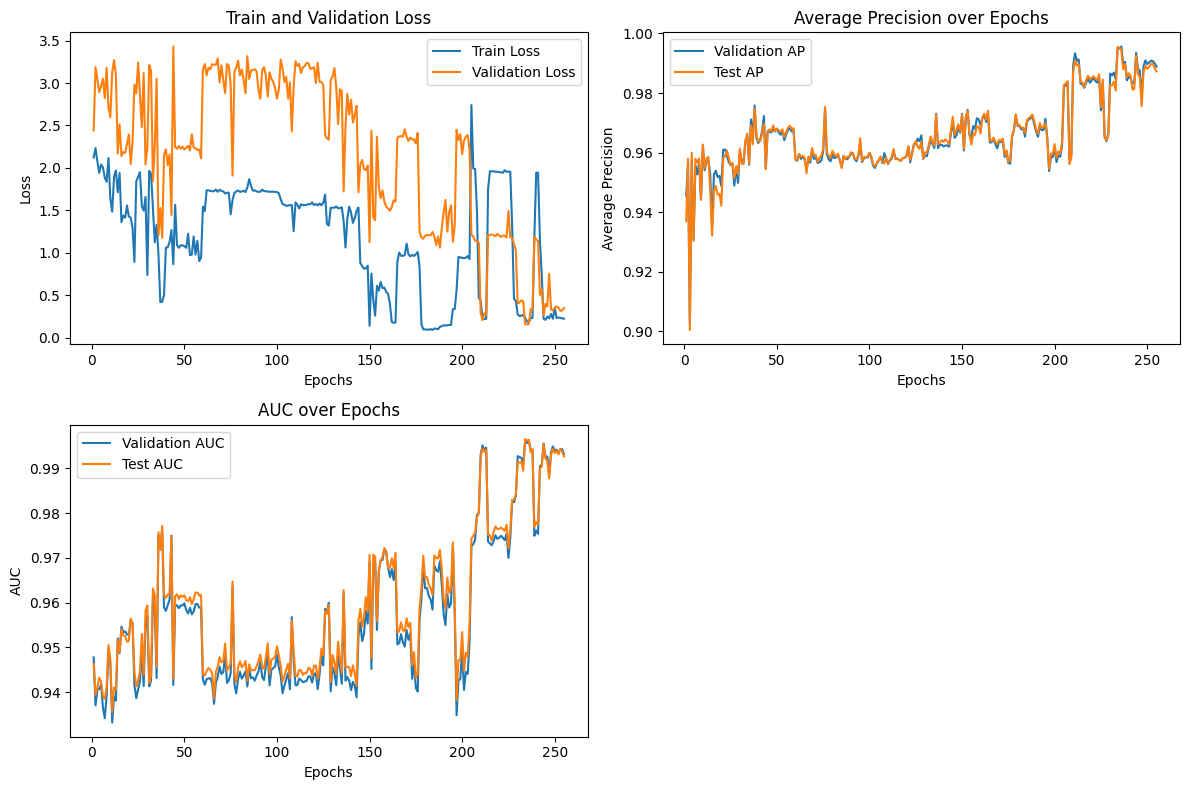

In [ ]:
#Chunked data passing to FNN model
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import average_precision_score, roc_auc_score
import matplotlib.pyplot as plt
import os

# Load and preprocess data
data_path = '/content/dataset_invade.csv'
data = pd.read_csv(data_path)
features = data.drop(columns=['attack'])
target = data['attack'].apply(lambda x: 1 if x == 'Yes' else 0)

# Convert categorical columns to one-hot encoded columns
non_numeric_columns = features.select_dtypes(include=['object']).columns
features = pd.get_dummies(features, columns=non_numeric_columns)

# Convert boolean columns to integers
for col in features.select_dtypes(include=['bool']).columns:
    features[col] = features[col].astype(int)

# Ensure all columns are now numeric
print(features.dtypes)

# Convert to PyTorch tensors
X_tensor = torch.tensor(features.values, dtype=torch.float32)
y_tensor = torch.tensor(target.values, dtype=torch.float32)

# Split the data into smaller datasets and save them to Google Drive
num_chunks = 5  # Define how many chunks you want
chunk_size = len(X_tensor) // num_chunks

for i in range(num_chunks):
    start_idx = i * chunk_size
    end_idx = (i + 1) * chunk_size if i < num_chunks - 1 else len(X_tensor)
    X_chunk = X_tensor[start_idx:end_idx]
    y_chunk = y_tensor[start_idx:end_idx]

    chunk_path = f'/content/chunk_{i}.pt'
    torch.save((X_chunk, y_chunk), chunk_path)
    print(f'Saved chunk {i} to {chunk_path}')

# Create a small validation set from the original data
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the model, loss function, and optimizer
class SimpleNN(torch.nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

input_dim = X_tensor.shape[1]  # Adjust this based on your data
model = SimpleNN(input_dim)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(loader, model, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(loader.dataset)

# Evaluation function
def evaluate_model(loader, model, criterion):
    model.eval()
    running_loss = 0.0
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            running_loss += loss.item() * inputs.size(0)
            all_outputs.append(outputs.squeeze().cpu())
            all_labels.append(labels.cpu())
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)
    return running_loss / len(loader.dataset), all_outputs, all_labels

# Check if there is a previously saved model
model_path = '/content/model.pth'
start_epoch = 1

if os.path.exists(model_path):
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming training from epoch {start_epoch}")

# Initialize lists to store metrics
chunk_train_losses = []
chunk_val_losses = []
chunk_val_aps = []
chunk_val_aucs = []
chunk_test_aps = []
chunk_test_aucs = []

# Training loop with data chunks
num_chunks = 5  # Must match the number of chunks created
num_epochs = 51  # Adjust as needed for each chunk

for chunk_idx in range(num_chunks):
    # Load the current chunk
    chunk_path = f'/content/chunk_{chunk_idx}.pt'
    X_chunk, y_chunk = torch.load(chunk_path)

    # Create DataLoader for the current chunk
    train_dataset = TensorDataset(X_chunk, y_chunk)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    for epoch in range(1, num_epochs + 1):
        train_loss = train_model(train_loader, model, optimizer, criterion)
        val_loss, val_outputs, val_labels = evaluate_model(val_loader, model, criterion)
        test_loss, test_outputs, test_labels = evaluate_model(test_loader, model, criterion)

        val_ap = average_precision_score(val_labels, val_outputs)
        val_auc = roc_auc_score(val_labels, val_outputs)
        test_ap = average_precision_score(test_labels, test_outputs)
        test_auc = roc_auc_score(test_labels, test_outputs)

        chunk_train_losses.append(train_loss)
        chunk_val_losses.append(val_loss)
        chunk_val_aps.append(val_ap)
        chunk_val_aucs.append(val_auc)
        chunk_test_aps.append(test_ap)
        chunk_test_aucs.append(test_auc)

        print(f'Chunk: {chunk_idx+1}/{num_chunks}, Epoch: {epoch:02d}, Loss: {train_loss:.4f}')
        print(f'Val AP: {val_ap:.4f}, Val AUC: {val_auc:.4f}')
        print(f'Test AP: {test_ap:.4f}, Test AUC: {test_auc:.4f}')

        # Save the model after each chunk
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, model_path)

# Plotting the results
epochs = range(1, num_chunks * num_epochs + 1)
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs, chunk_train_losses, label='Train Loss')
plt.plot(epochs, chunk_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')

plt.subplot(2, 2, 2)
plt.plot(epochs, chunk_val_aps, label='Validation AP')
plt.plot(epochs, chunk_test_aps, label='Test AP')
plt.xlabel('Epochs')
plt.ylabel('Average Precision')
plt.legend()
plt.title('Average Precision over Epochs')

plt.subplot(2, 2, 3)
plt.plot(epochs, chunk_val_aucs, label='Validation AUC')
plt.plot(epochs, chunk_test_aucs, label='Test AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.title('AUC over Epochs')

plt.tight_layout()
plt.show()


duration          int64
src_bytes         int64
dst_bytes         int64
land              int64
wrong_fragment    int64
                  ...  
flag_S1           int64
flag_S2           int64
flag_S3           int64
flag_SF           int64
flag_SH           int64
Length: 104, dtype: object
torch.Size([148517, 104]) torch.Size([148517])
Epoch: 01, Loss: 2.3958
Val AP: 0.9294, Val AUC: 0.9491
Test AP: 0.9243, Test AUC: 0.9490
Epoch: 02, Loss: 0.4814
Val AP: 0.9796, Val AUC: 0.9835
Test AP: 0.9801, Test AUC: 0.9845
Epoch: 03, Loss: 0.2107
Val AP: 0.9861, Val AUC: 0.9885
Test AP: 0.9865, Test AUC: 0.9895
Epoch: 04, Loss: 0.1714
Val AP: 0.9875, Val AUC: 0.9902
Test AP: 0.9879, Test AUC: 0.9910
Epoch: 05, Loss: 0.1750
Val AP: 0.9867, Val AUC: 0.9891
Test AP: 0.9874, Test AUC: 0.9901
Epoch: 06, Loss: 0.1573
Val AP: 0.9866, Val AUC: 0.9901
Test AP: 0.9873, Test AUC: 0.9913
Epoch: 07, Loss: 0.1594
Val AP: 0.9883, Val AUC: 0.9913
Test AP: 0.9887, Test AUC: 0.9921
Epoch: 08, Loss: 0.1583
Val AP: 

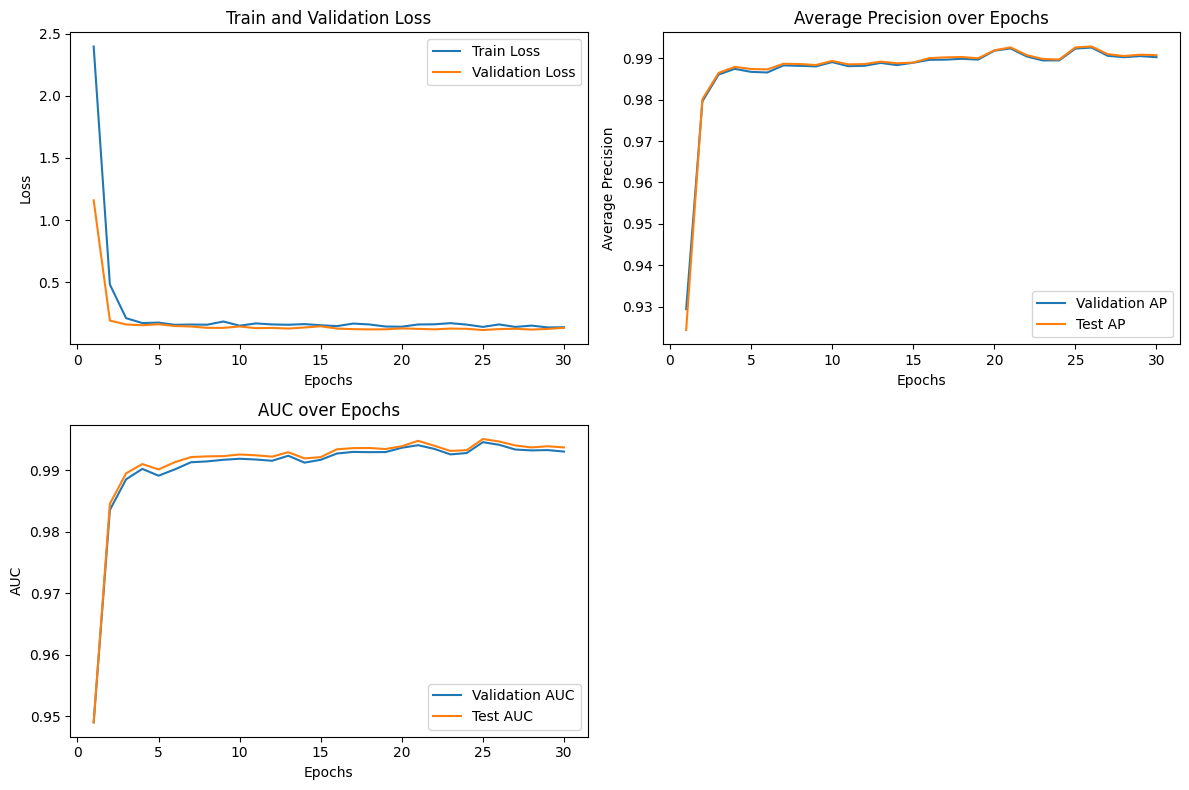

In [ ]:
#Regularization and dropout additions to base FNN model
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import average_precision_score, roc_auc_score
import matplotlib.pyplot as plt

# Load and preprocess data
data_path = '/content/dataset_invade.csv'
data = pd.read_csv(data_path)
features = data.drop(columns=['attack'])
target = data['attack'].apply(lambda x: 1 if x == 'Yes' else 0)

# Convert categorical columns to one-hot encoded columns
non_numeric_columns = features.select_dtypes(include=['object']).columns
features = pd.get_dummies(features, columns=non_numeric_columns)

# Convert boolean columns to integers
for col in features.select_dtypes(include=['bool']).columns:
    features[col] = features[col].astype(int)

# Ensure all columns are now numeric
print(features.dtypes)

# Convert to PyTorch tensors
X_tensor = torch.tensor(features.values, dtype=torch.float32)
y_tensor = torch.tensor(target.values, dtype=torch.float32)

# Display the shapes of the tensors
print(X_tensor.shape, y_tensor.shape)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create DataLoader for each dataset
batch_size = 64

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the model, loss function, and optimizer
class SimpleNN(torch.nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 1)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        return x

input_dim = X_tensor.shape[1]
model = SimpleNN(input_dim)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(loader):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(loader.dataset)

# Evaluation function
def evaluate_model(loader):
    model.eval()
    running_loss = 0.0
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            running_loss += loss.item() * inputs.size(0)
            all_outputs.append(outputs.squeeze().cpu())
            all_labels.append(labels.cpu())
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)
    return running_loss / len(loader.dataset), all_outputs, all_labels

# Training loop
num_epochs = 30
train_losses = []
val_losses = []
val_aps = []
val_aucs = []
test_aps = []
test_aucs = []

for epoch in range(1, num_epochs+1):
    train_loss = train_model(train_loader)
    val_loss, val_outputs, val_labels = evaluate_model(val_loader)
    test_loss, test_outputs, test_labels = evaluate_model(test_loader)

    val_ap = average_precision_score(val_labels, val_outputs)
    val_auc = roc_auc_score(val_labels, val_outputs)
    test_ap = average_precision_score(test_labels, test_outputs)
    test_auc = roc_auc_score(test_labels, test_outputs)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_aps.append(val_ap)
    val_aucs.append(val_auc)
    test_aps.append(test_ap)
    test_aucs.append(test_auc)

    print(f'Epoch: {epoch:02d}, Loss: {train_loss:.4f}')
    print(f'Val AP: {val_ap:.4f}, Val AUC: {val_auc:.4f}')
    print(f'Test AP: {test_ap:.4f}, Test AUC: {test_auc:.4f}')

# Plotting the results
epochs = range(1, num_epochs+1)
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')

plt.subplot(2, 2, 2)
plt.plot(epochs, val_aps, label='Validation AP')
plt.plot(epochs, test_aps, label='Test AP')
plt.xlabel('Epochs')
plt.ylabel('Average Precision')
plt.legend()
plt.title('Average Precision over Epochs')

plt.subplot(2, 2, 3)
plt.plot(epochs, val_aucs, label='Validation AUC')
plt.plot(epochs, test_aucs, label='Test AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.title('AUC over Epochs')

plt.tight_layout()
plt.show()


In [ ]:
#QNN integrated into previous FNN Model

In [ ]:
!pip install pennylane
!pip install pennylane-qiskit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.9/249.9 kB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 100.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

duration          int64
src_bytes         int64
dst_bytes         int64
land              int64
wrong_fragment    int64
                  ...  
flag_S1           int64
flag_S2           int64
flag_S3           int64
flag_SF           int64
flag_SH           int64
Length: 104, dtype: object
torch.Size([148517, 104]) torch.Size([148517])
Epoch: 01, Loss: 0.4522
Val AP: 0.9247, Val AUC: 0.8942
Test AP: 0.9263, Test AUC: 0.8955
Epoch: 02, Loss: 0.3880
Val AP: 0.9339, Val AUC: 0.9101
Test AP: 0.9329, Test AUC: 0.9082
Epoch: 03, Loss: 0.3766
Val AP: 0.9298, Val AUC: 0.9012
Test AP: 0.9315, Test AUC: 0.9043
Epoch: 04, Loss: 0.3701
Val AP: 0.9354, Val AUC: 0.9108
Test AP: 0.9340, Test AUC: 0.9096
Epoch: 05, Loss: 0.3626
Val AP: 0.9406, Val AUC: 0.9190
Test AP: 0.9415, Test AUC: 0.9213
Epoch: 06, Loss: 0.3562
Val AP: 0.9377, Val AUC: 0.9169
Test AP: 0.9379, Test AUC: 0.9168
Epoch: 07, Loss: 0.3599
Val AP: 0.9312, Val AUC: 0.9035
Test AP: 0.9313, Test AUC: 0.9044
Epoch: 08, Loss: 0.3608
Val AP: 

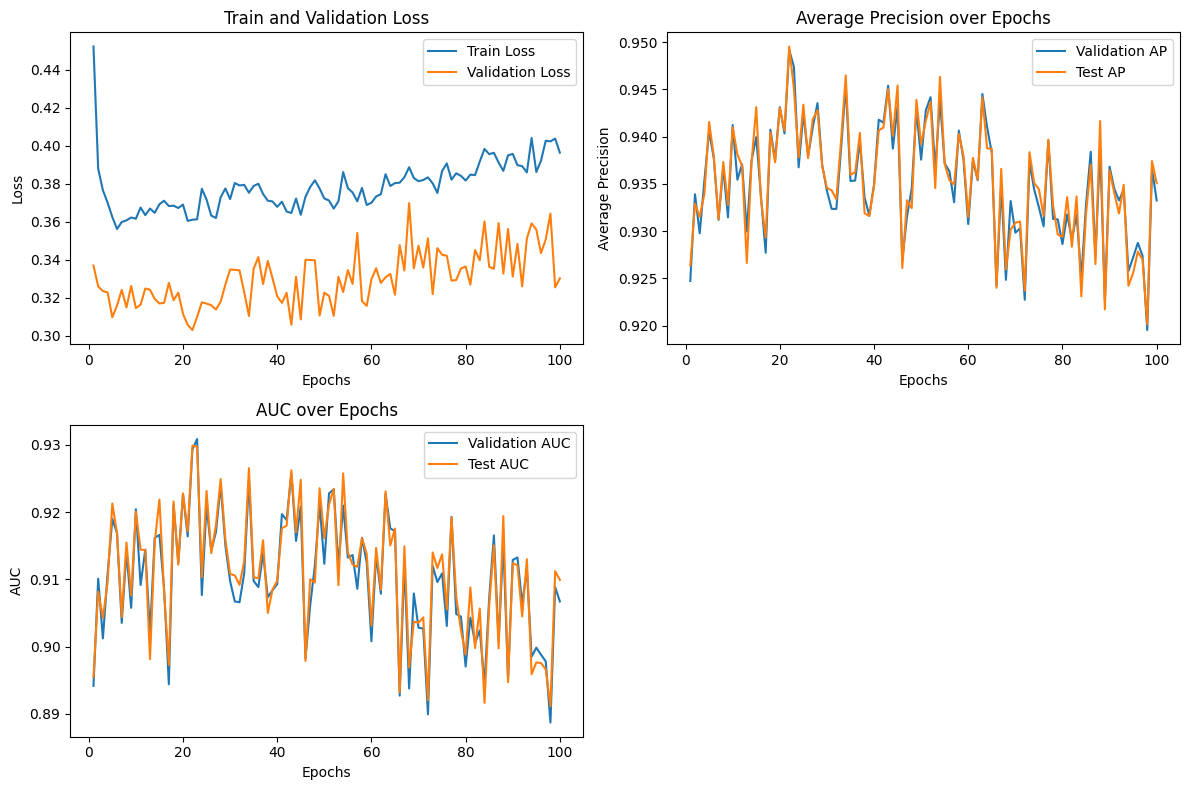

In [ ]:
#First implementation of the QNN layer replacing the basic FNN model
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import average_precision_score, roc_auc_score
import matplotlib.pyplot as plt

# Load and preprocess data
data_path = '/content/dataset_invade.csv'
data = pd.read_csv(data_path)
features = data.drop(columns=['attack'])
target = data['attack'].apply(lambda x: 1 if x == 'Yes' else 0)

# Convert categorical columns to one-hot encoded columns
non_numeric_columns = features.select_dtypes(include=['object']).columns
features = pd.get_dummies(features, columns=non_numeric_columns)

# Convert boolean columns to integers
for col in features.select_dtypes(include=['bool']).columns:
    features[col] = features[col].astype(int)

# Ensure all columns are now numeric
print(features.dtypes)

# Convert to PyTorch tensors
X_tensor = torch.tensor(features.values, dtype=torch.float32)
y_tensor = torch.tensor(target.values, dtype=torch.float32)

# Display the shapes of the tensors
print(X_tensor.shape, y_tensor.shape)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create DataLoader for each dataset
batch_size = 64

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the Quantum Neural Network (QNN) model
class QuantumLayer(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QuantumLayer, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.linear(x)
        x = torch.sin(x)  # Apply a quantum-inspired non-linearity
        return x

class QuantumNN(torch.nn.Module):
    def __init__(self, input_dim):
        super(QuantumNN, self).__init__()
        self.q_layer1 = QuantumLayer(input_dim, 128)
        self.q_layer2 = QuantumLayer(128, 64)
        self.fc = torch.nn.Linear(64, 1)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.q_layer1(x))
        x = self.dropout(x)
        x = torch.relu(self.q_layer2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc(x))
        return x

input_dim = X_tensor.shape[1]
model = QuantumNN(input_dim)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(loader):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(loader.dataset)

# Evaluation function
def evaluate_model(loader):
    model.eval()
    running_loss = 0.0
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            running_loss += loss.item() * inputs.size(0)
            all_outputs.append(outputs.squeeze().cpu())
            all_labels.append(labels.cpu())
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)
    return running_loss / len(loader.dataset), all_outputs, all_labels

# Training loop
num_epochs = 100
train_losses = []
val_losses = []
val_aps = []
val_aucs = []
test_aps = []
test_aucs = []

for epoch in range(1, num_epochs + 1):
    train_loss = train_model(train_loader)
    val_loss, val_outputs, val_labels = evaluate_model(val_loader)
    test_loss, test_outputs, test_labels = evaluate_model(test_loader)

    val_ap = average_precision_score(val_labels, val_outputs)
    val_auc = roc_auc_score(val_labels, val_outputs)
    test_ap = average_precision_score(test_labels, test_outputs)
    test_auc = roc_auc_score(test_labels, test_outputs)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_aps.append(val_ap)
    val_aucs.append(val_auc)
    test_aps.append(test_ap)
    test_aucs.append(test_auc)

    print(f'Epoch: {epoch:02d}, Loss: {train_loss:.4f}')
    print(f'Val AP: {val_ap:.4f}, Val AUC: {val_auc:.4f}')
    print(f'Test AP: {test_ap:.4f}, Test AUC: {test_auc:.4f}')

# Plotting the results
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')

plt.subplot(2, 2, 2)
plt.plot(epochs, val_aps, label='Validation AP')
plt.plot(epochs, test_aps, label='Test AP')
plt.xlabel('Epochs')
plt.ylabel('Average Precision')
plt.legend()
plt.title('Average Precision over Epochs')

plt.subplot(2, 2, 3)
plt.plot(epochs, val_aucs, label='Validation AUC')
plt.plot(epochs, test_aucs, label='Test AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.title('AUC over Epochs')

plt.tight_layout()
plt.show()


duration          int64
src_bytes         int64
dst_bytes         int64
land              int64
wrong_fragment    int64
                  ...  
flag_S1           int64
flag_S2           int64
flag_S3           int64
flag_SF           int64
flag_SH           int64
Length: 104, dtype: object
torch.Size([148517, 104]) torch.Size([148517])
Epoch: 01, Loss: 0.1111
Val AP: 0.9975, Val AUC: 0.9976
Test AP: 0.9977, Test AUC: 0.9979
Epoch: 02, Loss: 0.0646
Val AP: 0.9983, Val AUC: 0.9983
Test AP: 0.9983, Test AUC: 0.9985
Epoch: 03, Loss: 0.0587
Val AP: 0.9985, Val AUC: 0.9985
Test AP: 0.9986, Test AUC: 0.9987
Epoch: 04, Loss: 0.0539
Val AP: 0.9986, Val AUC: 0.9987
Test AP: 0.9987, Test AUC: 0.9987
Epoch: 05, Loss: 0.0529
Val AP: 0.9987, Val AUC: 0.9987
Test AP: 0.9988, Test AUC: 0.9989
Epoch: 06, Loss: 0.0515
Val AP: 0.9987, Val AUC: 0.9988
Test AP: 0.9987, Test AUC: 0.9988
Epoch: 07, Loss: 0.0501
Val AP: 0.9988, Val AUC: 0.9989
Test AP: 0.9988, Test AUC: 0.9989
Epoch: 08, Loss: 0.0495
Val AP: 

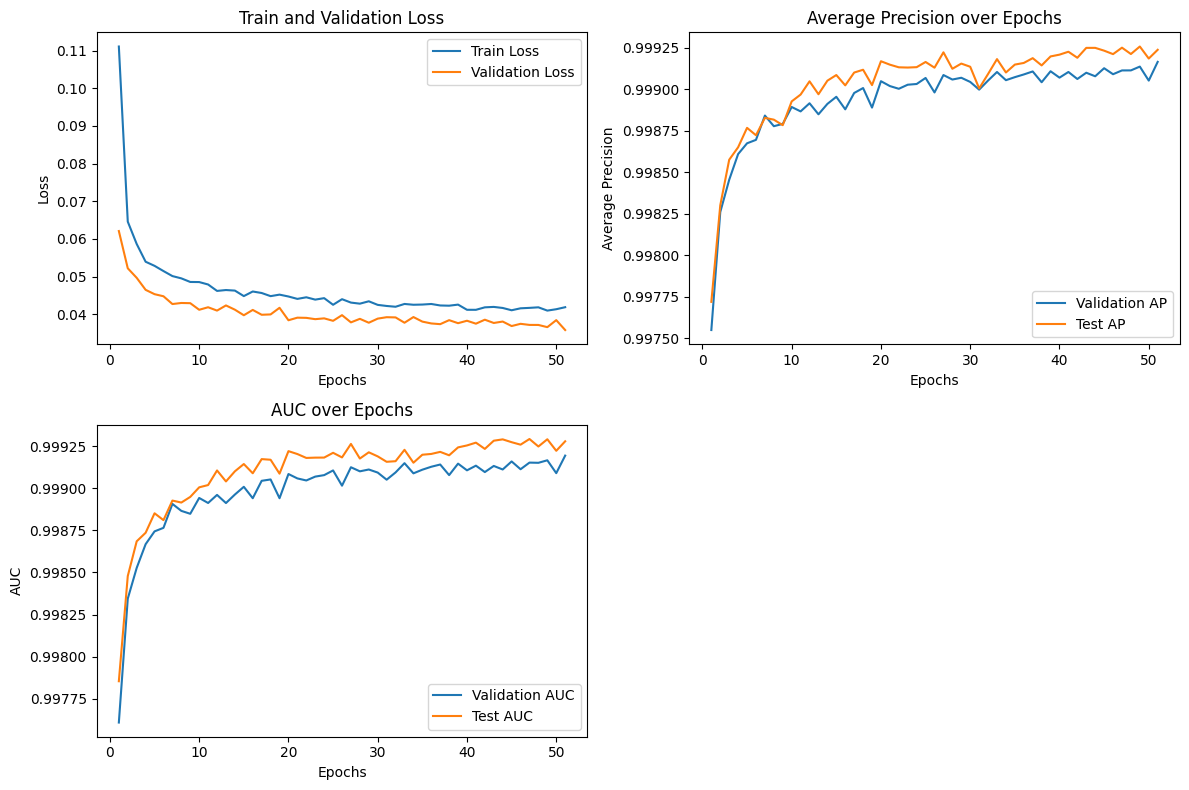

In [ ]:
#QNN Enhanced FNN
#Feature scaling is applied using StandardScaler. Scaling the features ensures that all input features
#contribute equally to the model training process and prevents features with larger ranges from
#dominating the training process. This can lead to faster convergence and better performance.
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import average_precision_score, roc_auc_score
import matplotlib.pyplot as plt

# Load and preprocess data
data_path = '/content/dataset_invade.csv'
data = pd.read_csv(data_path)
features = data.drop(columns=['attack'])
target = data['attack'].apply(lambda x: 1 if x == 'Yes' else 0)

# Convert categorical columns to one-hot encoded columns
non_numeric_columns = features.select_dtypes(include=['object']).columns
features = pd.get_dummies(features, columns=non_numeric_columns)

# Convert boolean columns to integers
for col in features.select_dtypes(include=['bool']).columns:
    features[col] = features[col].astype(int)

# Ensure all columns are now numeric
print(features.dtypes)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Convert to PyTorch tensors
X_tensor = torch.tensor(features, dtype=torch.float32)
y_tensor = torch.tensor(target.values, dtype=torch.float32)

# Display the shapes of the tensors
print(X_tensor.shape, y_tensor.shape)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create DataLoader for each dataset
batch_size = 64

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the Quantum Neural Network (QNN) model
class QuantumLayer(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QuantumLayer, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.linear(x)
        x = torch.sin(x)  # Apply a quantum-inspired non-linearity
        return x

class QuantumNN(torch.nn.Module):
    def __init__(self, input_dim):
        super(QuantumNN, self).__init__()
        self.q_layer1 = QuantumLayer(input_dim, 128)
        self.q_layer2 = QuantumLayer(128, 64)
        self.fc = torch.nn.Linear(64, 1)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.q_layer1(x))
        x = self.dropout(x)
        x = torch.relu(self.q_layer2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc(x))
        return x

input_dim = X_tensor.shape[1]
model = QuantumNN(input_dim)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(loader):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(loader.dataset)

# Evaluation function
def evaluate_model(loader):
    model.eval()
    running_loss = 0.0
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            running_loss += loss.item() * inputs.size(0)
            all_outputs.append(outputs.squeeze().cpu())
            all_labels.append(labels.cpu())
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)
    return running_loss / len(loader.dataset), all_outputs, all_labels

# Training loop
num_epochs = 51
train_losses = []
val_losses = []
val_aps = []
val_aucs = []
test_aps = []
test_aucs = []

for epoch in range(1, num_epochs + 1):
    train_loss = train_model(train_loader)
    val_loss, val_outputs, val_labels = evaluate_model(val_loader)
    test_loss, test_outputs, test_labels = evaluate_model(test_loader)

    val_ap = average_precision_score(val_labels, val_outputs)
    val_auc = roc_auc_score(val_labels, val_outputs)
    test_ap = average_precision_score(test_labels, test_outputs)
    test_auc = roc_auc_score(test_labels, test_outputs)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_aps.append(val_ap)
    val_aucs.append(val_auc)
    test_aps.append(test_ap)
    test_aucs.append(test_auc)

    print(f'Epoch: {epoch:02d}, Loss: {train_loss:.4f}')
    print(f'Val AP: {val_ap:.4f}, Val AUC: {val_auc:.4f}')
    print(f'Test AP: {test_ap:.4f}, Test AUC: {test_auc:.4f}')

# Plotting the results
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')

plt.subplot(2, 2, 2)
plt.plot(epochs, val_aps, label='Validation AP')
plt.plot(epochs, test_aps, label='Test AP')
plt.xlabel('Epochs')
plt.ylabel('Average Precision')
plt.legend()
plt.title('Average Precision over Epochs')

plt.subplot(2, 2, 3)
plt.plot(epochs, val_aucs, label='Validation AUC')
plt.plot(epochs, test_aucs, label='Test AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.title('AUC over Epochs')

plt.tight_layout()
plt.show()


duration          int64
src_bytes         int64
dst_bytes         int64
land              int64
wrong_fragment    int64
                  ...  
flag_S1           int64
flag_S2           int64
flag_S3           int64
flag_SF           int64
flag_SH           int64
Length: 104, dtype: object
torch.Size([148517, 104]) torch.Size([148517])
Epoch: 01, Loss: 0.1139
Val AP: 0.9975, Val AUC: 0.9976
Test AP: 0.9977, Test AUC: 0.9978
Epoch: 02, Loss: 0.0778
Val AP: 0.9980, Val AUC: 0.9981
Test AP: 0.9982, Test AUC: 0.9983
Epoch: 03, Loss: 0.0706
Val AP: 0.9981, Val AUC: 0.9982
Test AP: 0.9982, Test AUC: 0.9984
Epoch: 04, Loss: 0.0670
Val AP: 0.9984, Val AUC: 0.9984
Test AP: 0.9985, Test AUC: 0.9986
Epoch: 05, Loss: 0.0622
Val AP: 0.9985, Val AUC: 0.9986
Test AP: 0.9986, Test AUC: 0.9987
Epoch: 06, Loss: 0.0610
Val AP: 0.9986, Val AUC: 0.9986
Test AP: 0.9986, Test AUC: 0.9987
Epoch: 07, Loss: 0.0585
Val AP: 0.9987, Val AUC: 0.9988
Test AP: 0.9988, Test AUC: 0.9989
Epoch: 08, Loss: 0.0568
Val AP: 

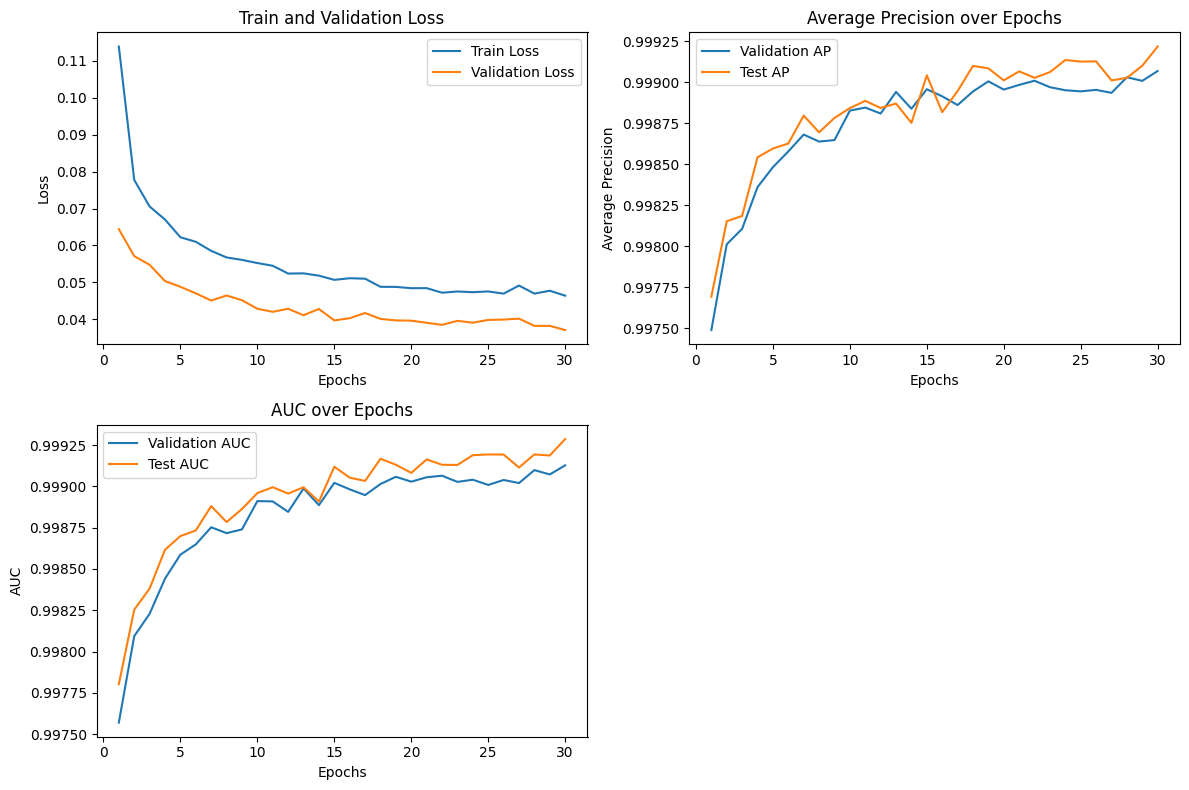

In [ ]:
#Batch normalization, Feature Scaling, Hyperparameter tuning, regularization of FNN enhanced by QNN
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import average_precision_score, roc_auc_score
import matplotlib.pyplot as plt

# Load and preprocess data
data_path = '/content/dataset_invade.csv'
data = pd.read_csv(data_path)
features = data.drop(columns=['attack'])
target = data['attack'].apply(lambda x: 1 if x == 'Yes' else 0)

# Convert categorical columns to one-hot encoded columns
non_numeric_columns = features.select_dtypes(include=['object']).columns
features = pd.get_dummies(features, columns=non_numeric_columns)

# Convert boolean columns to integers
for col in features.select_dtypes(include=['bool']).columns:
    features[col] = features[col].astype(int)

# Ensure all columns are now numeric
print(features.dtypes)

# Feature Scaling
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Convert to PyTorch tensors
X_tensor = torch.tensor(features, dtype=torch.float32)
y_tensor = torch.tensor(target.values, dtype=torch.float32)

# Display the shapes of the tensors
print(X_tensor.shape, y_tensor.shape)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create DataLoader for each dataset
batch_size = 64

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the Quantum Neural Network (QNN) model
class QuantumLayer(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QuantumLayer, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.linear(x)
        x = torch.sin(x)  # Apply a quantum-inspired non-linearity
        return x

class QuantumNN(torch.nn.Module):
    def __init__(self, input_dim):
        super(QuantumNN, self).__init__()
        self.q_layer1 = QuantumLayer(input_dim, 128)
        self.q_layer2 = QuantumLayer(128, 64)
        self.fc = torch.nn.Linear(64, 1)
        self.dropout = torch.nn.Dropout(0.5)
        self.batch_norm1 = torch.nn.BatchNorm1d(128)
        self.batch_norm2 = torch.nn.BatchNorm1d(64)

    def forward(self, x):
        x = torch.relu(self.batch_norm1(self.q_layer1(x)))
        x = self.dropout(x)
        x = torch.relu(self.batch_norm2(self.q_layer2(x)))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc(x))
        return x

input_dim = X_tensor.shape[1]
model = QuantumNN(input_dim)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(loader):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(loader.dataset)

# Evaluation function
def evaluate_model(loader):
    model.eval()
    running_loss = 0.0
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            running_loss += loss.item() * inputs.size(0)
            all_outputs.append(outputs.squeeze().cpu())
            all_labels.append(labels.cpu())
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)
    return running_loss / len(loader.dataset), all_outputs, all_labels

# Training loop
num_epochs = 51
train_losses = []
val_losses = []
val_aps = []
val_aucs = []
test_aps = []
test_aucs = []

for epoch in range(1, num_epochs + 1):
    train_loss = train_model(train_loader)
    val_loss, val_outputs, val_labels = evaluate_model(val_loader)
    test_loss, test_outputs, test_labels = evaluate_model(test_loader)

    val_ap = average_precision_score(val_labels, val_outputs)
    val_auc = roc_auc_score(val_labels, val_outputs)
    test_ap = average_precision_score(test_labels, test_outputs)
    test_auc = roc_auc_score(test_labels, test_outputs)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_aps.append(val_ap)
    val_aucs.append(val_auc)
    test_aps.append(test_ap)
    test_aucs.append(test_auc)

    print(f'Epoch: {epoch:02d}, Loss: {train_loss:.4f}')
    print(f'Val AP: {val_ap:.4f}, Val AUC: {val_auc:.4f}')
    print(f'Test AP: {test_ap:.4f}, Test AUC: {test_auc:.4f}')

# Plotting the results
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')

plt.subplot(2, 2, 2)
plt.plot(epochs, val_aps, label='Validation AP')
plt.plot(epochs, test_aps, label='Test AP')
plt.xlabel('Epochs')
plt.ylabel('Average Precision')
plt.legend()
plt.title('Average Precision over Epochs')

plt.subplot(2, 2, 3)
plt.plot(epochs, val_aucs, label='Validation AUC')
plt.plot(epochs, test_aucs, label='Test AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.title('AUC over Epochs')

plt.tight_layout()
plt.show()


In [ ]:
# Visual representations of the dataset used
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Load the dataset
data_path = '/content/dataset_invade.csv'
data = pd.read_csv(data_path)

# Convert categorical columns to one-hot encoded columns
non_numeric_columns = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=non_numeric_columns)

# Convert boolean columns to integers
for col in data.select_dtypes(include=['bool']).columns:
    data[col] = data[col].astype(int)

# Feature scaling
scaler = StandardScaler()
data[data.columns] = scaler.fit_transform(data)

# Plot the distribution of attacks
plt.figure(figsize=(10, 6))
sns.countplot(x='attack_Yes', data=data)
plt.title('Distribution of Attacks')
plt.xlabel('Attack')
plt.ylabel('Count')
plt.show()

# Plot a heatmap of the feature correlations
plt.figure(figsize=(18, 16))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# Plot the distribution of selected features
features_to_plot = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 'serror_rate', 'rerror_rate', 'same_srv_rate', 'diff_srv_rate']

plt.figure(figsize=(20, 15))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# Scatter plot between src_bytes and dst_bytes
plt.figure(figsize=(10, 6))
sns.scatterplot(x='src_bytes', y='dst_bytes', hue='attack_Yes', data=data)
plt.title('Scatter Plot between src_bytes and dst_bytes')
plt.xlabel('src_bytes')
plt.ylabel('dst_bytes')
plt.legend(title='Attack')
plt.show()

# Pairplot for selected features to visualize relationships
features_to_pairplot = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 'attack_Yes']
sns.pairplot(data[features_to_pairplot], hue='attack_Yes', diag_kind='kde')
plt.show()


KeyError: 'attack'

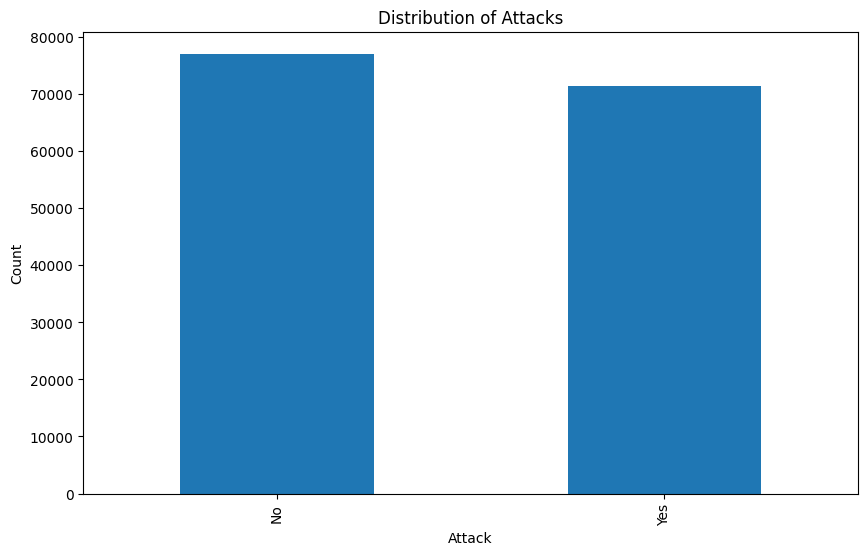

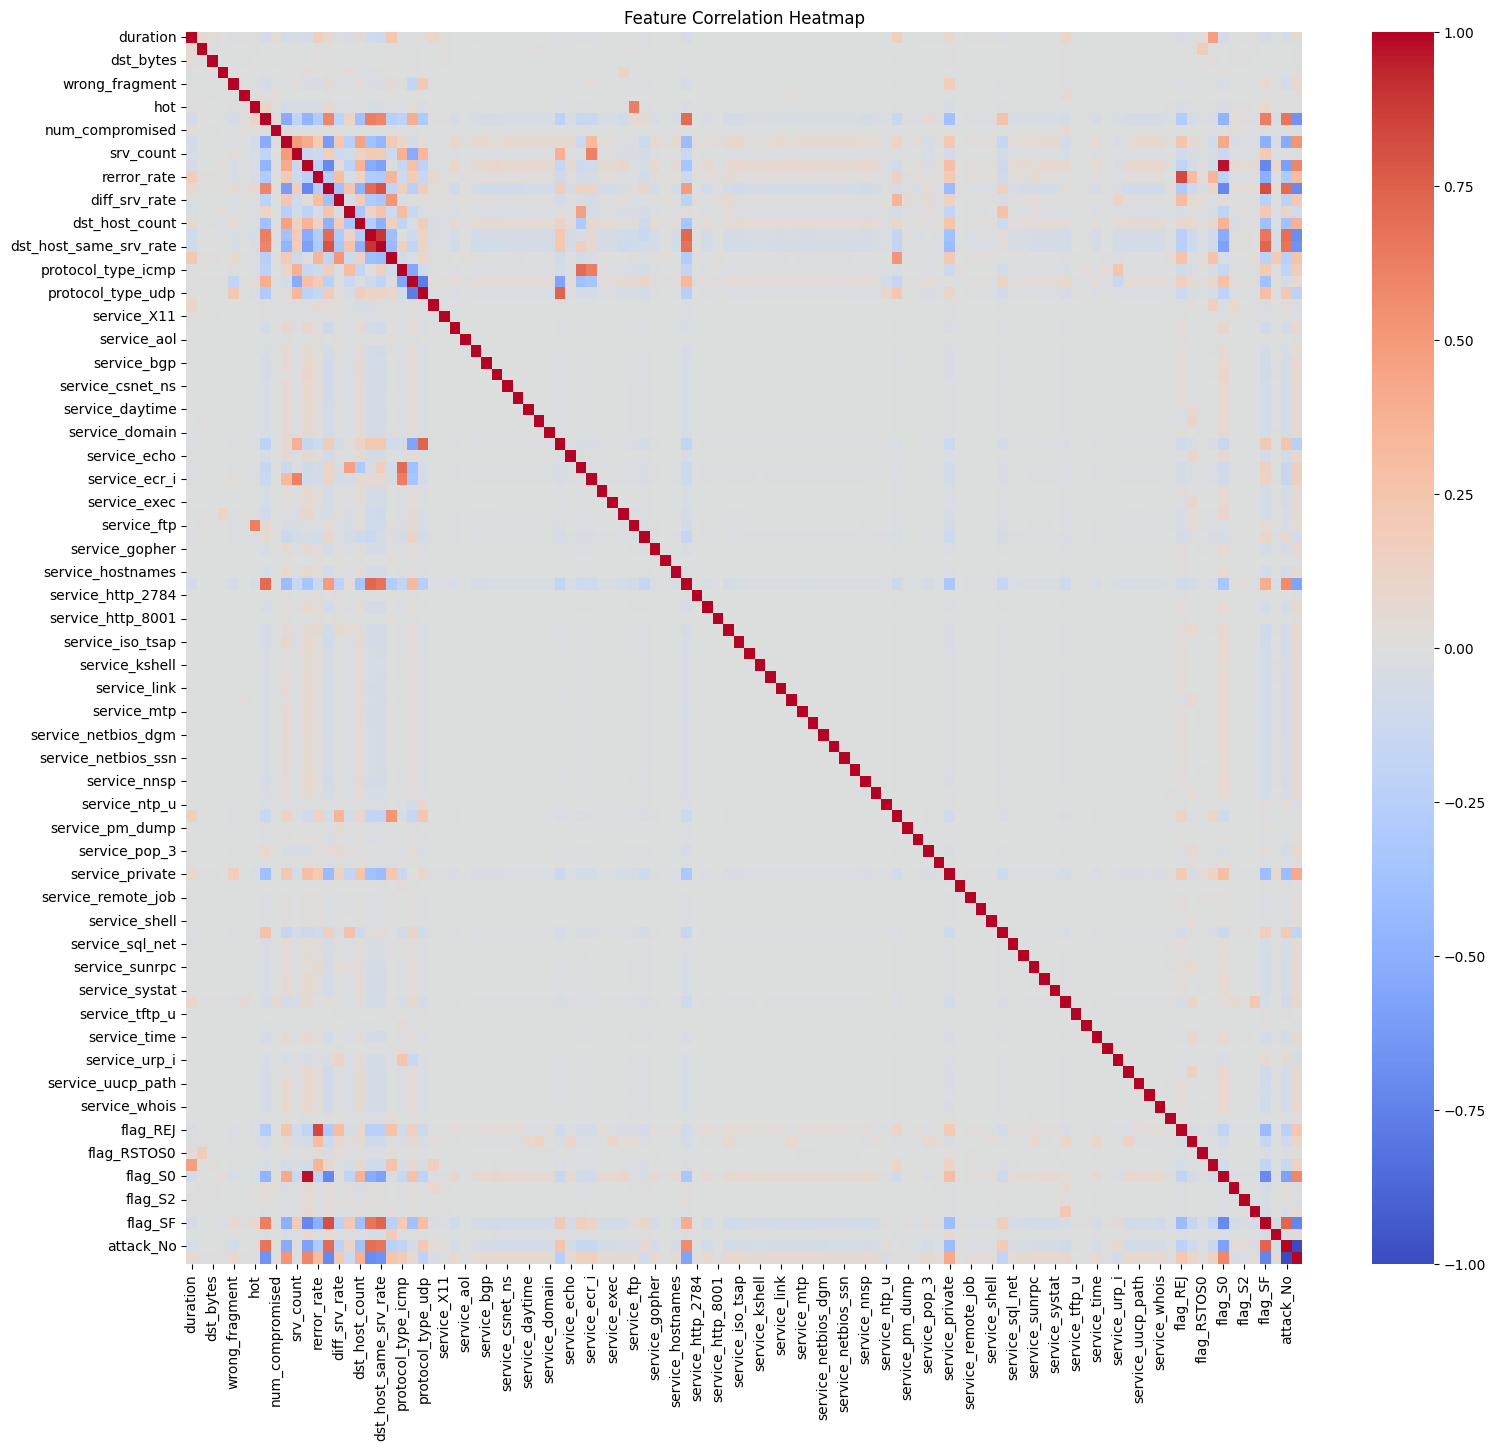

KeyboardInterrupt: 

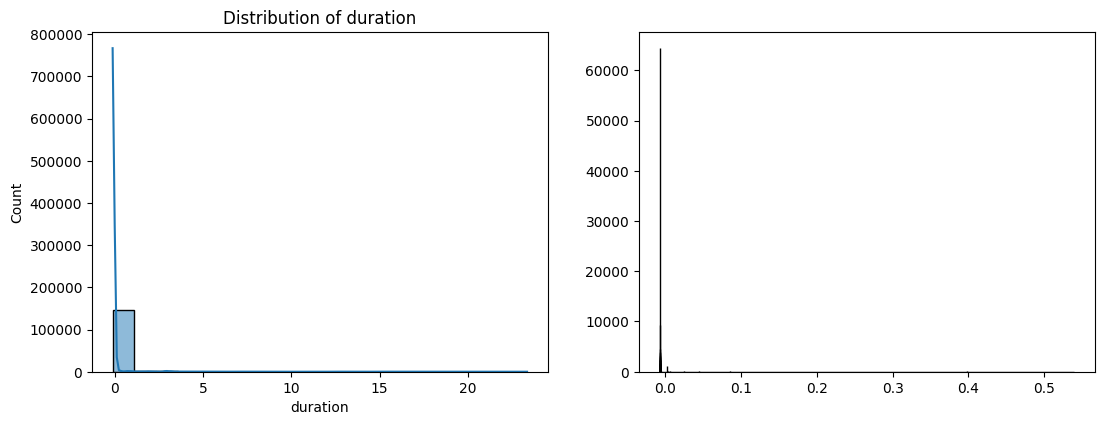

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Load the dataset
data_path = '/content/dataset_invade.csv'
data = pd.read_csv(data_path)

# Convert categorical columns to one-hot encoded columns
non_numeric_columns = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=non_numeric_columns)

# Convert boolean columns to integers
for col in data.select_dtypes(include=['bool']).columns:
    data[col] = data[col].astype(int)

# Feature scaling
scaler = StandardScaler()
data[data.columns] = scaler.fit_transform(data)

# Plot the distribution of attacks
plt.figure(figsize=(10, 6))
data['attack_Yes'].value_counts().plot(kind='bar')
plt.title('Distribution of Attacks')
plt.xlabel('Attack')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

# Plot a heatmap of the feature correlations
plt.figure(figsize=(18, 16))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# Plot the distribution of selected features
features_to_plot = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 'serror_rate', 'rerror_rate', 'same_srv_rate', 'diff_srv_rate']

plt.figure(figsize=(20, 15))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# Scatter plot between src_bytes and dst_bytes
plt.figure(figsize=(10, 6))
sns.scatterplot(x='src_bytes', y='dst_bytes', hue='attack_Yes', data=data)
plt.title('Scatter Plot between src_bytes and dst_bytes')
plt.xlabel('src_bytes')
plt.ylabel('dst_bytes')
plt.legend(title='Attack', labels=['No Attack', 'Attack'])
plt.show()

# Pairplot for selected features to visualize relationships
features_to_pairplot = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 'attack_Yes']
sns.pairplot(data[features_to_pairplot], hue='attack_Yes', diag_kind='kde')
plt.show()


In [ ]:
#Modify the models to identify the attacks and source of attacks

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load and preprocess data
data_path = '/content/dataset_invade.csv'
data = pd.read_csv(data_path)

# Convert categorical columns to one-hot encoded columns
non_numeric_columns = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=non_numeric_columns)

# Convert boolean columns to integers
for col in data.select_dtypes(include=['bool']).columns:
    data[col] = data[col].astype(int)

# Encode attack_type and source_ip
label_encoder_attack = LabelEncoder()
data['attack_type'] = label_encoder_attack.fit_transform(data['attack_type'])
label_encoder_source = LabelEncoder()
data['source_ip'] = label_encoder_source.fit_transform(data['source_ip'])

# Feature scaling
scaler = StandardScaler()
data[data.columns] = scaler.fit_transform(data)

# Split features and targets
features = data.drop(columns=['attack', 'attack_type', 'source_ip'])
attack_target = data['attack']
attack_type_target = data['attack_type']
source_target = data['source_ip']

# Convert to PyTorch tensors
X_tensor = torch.tensor(features.values, dtype=torch.float32)
attack_tensor = torch.tensor(attack_target.values, dtype=torch.float32)
attack_type_tensor = torch.tensor(attack_type_target.values, dtype=torch.long)
source_tensor = torch.tensor(source_target.values, dtype=torch.long)

# Split the data into training, validation, and test sets
X_train, X_temp, attack_train, attack_temp, attack_type_train, attack_type_temp, source_train, source_temp = train_test_split(
    X_tensor, attack_tensor, attack_type_tensor, source_tensor, test_size=0.3, random_state=42)
X_val, X_test, attack_val, attack_test, attack_type_val, attack_type_test, source_val, source_test = train_test_split(
    X_temp, attack_temp, attack_type_temp, source_temp, test_size=0.5, random_state=42)


ValueError: The dataset must contain 'attack_type' and 'source_ip' columns.

In [ ]:
#Preprocess the data

import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load and preprocess data
data_path = '/content/dataset_invade.csv'
data = pd.read_csv(data_path)

# Convert categorical columns to one-hot encoded columns
non_numeric_columns = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=non_numeric_columns)

# Convert boolean columns to integers
for col in data.select_dtypes(include=['bool']).columns:
    data[col] = data[col].astype(int)

# Encode attack_type and source_ip
label_encoder_attack = LabelEncoder()
data['attack_type'] = label_encoder_attack.fit_transform(data['attack_type'])
label_encoder_source = LabelEncoder()
data['source_ip'] = label_encoder_source.fit_transform(data['source_ip'])

# Feature scaling
scaler = StandardScaler()
data[data.columns] = scaler.fit_transform(data)

# Split features and targets
features = data.drop(columns=['attack', 'attack_type', 'source_ip'])
attack_target = data['attack']
attack_type_target = data['attack_type']
source_target = data['source_ip']

# Convert to PyTorch tensors
X_tensor = torch.tensor(features.values, dtype=torch.float32)
attack_tensor = torch.tensor(attack_target.values, dtype=torch.float32)
attack_type_tensor = torch.tensor(attack_type_target.values, dtype=torch.long)
source_tensor = torch.tensor(source_target.values, dtype=torch.long)

# Split the data into training, validation, and test sets
X_train, X_temp, attack_train, attack_temp, attack_type_train, attack_type_temp, source_train, source_temp = train_test_split(
    X_tensor, attack_tensor, attack_type_tensor, source_tensor, test_size=0.3, random_state=42)
X_val, X_test, attack_val, attack_test, attack_type_val, attack_type_test, source_val, source_test = train_test_split(
    X_temp, attack_temp, attack_type_temp, source_temp, test_size=0.5, random_state=42)


In [ ]:
### Modified FNN Model
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Load and preprocess data
data_path = '/content/dataset_invade.csv'
data = pd.read_csv(data_path)

# Encode target labels for attack, attack_type, and source
data['attack'] = data['attack'].apply(lambda x: 1 if x == 'Yes' else 0)
data['attack_type'] = data['attack_type'].astype('category').cat.codes
data['source_ip'] = data['source_ip'].astype('category').cat.codes

# Convert categorical columns to one-hot encoded columns
non_numeric_columns = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=non_numeric_columns)

# Convert boolean columns to integers
for col in data.select_dtypes(include=['bool']).columns:
    data[col] = data[col].astype(int)

# Ensure all columns are now numeric
print(data.dtypes)

# Split features and targets
features = data.drop(columns=['attack', 'attack_type', 'source_ip'])
target_attack = data['attack']
target_attack_type = data['attack_type']
target_source = data['source_ip']

# Convert to PyTorch tensors
X_tensor = torch.tensor(features.values, dtype=torch.float32)
y_tensor_attack = torch.tensor(target_attack.values, dtype=torch.float32)
y_tensor_attack_type = torch.tensor(target_attack_type.values, dtype=torch.long)
y_tensor_source = torch.tensor(target_source.values, dtype=torch.long)

# Display the shapes of the tensors
print(X_tensor.shape, y_tensor_attack.shape, y_tensor_attack_type.shape, y_tensor_source.shape)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train_attack, y_temp_attack, y_train_attack_type, y_temp_attack_type, y_train_source, y_temp_source = train_test_split(
    X_tensor, y_tensor_attack, y_tensor_attack_type, y_tensor_source, test_size=0.3, random_state=42)
X_val, X_test, y_val_attack, y_test_attack, y_val_attack_type, y_test_attack_type, y_val_source, y_test_source = train_test_split(
    X_temp, y_temp_attack, y_temp_attack_type, y_temp_source, test_size=0.5, random_state=42)

# Create DataLoader for each dataset
batch_size = 64

train_dataset = TensorDataset(X_train, y_train_attack, y_train_attack_type, y_train_source)
val_dataset = TensorDataset(X_val, y_val_attack, y_val_attack_type, y_val_source)
test_dataset = TensorDataset(X_test, y_test_attack, y_test_attack_type, y_test_source)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the model, loss function, and optimizer
class SimpleNN(torch.nn.Module):
    def __init__(self, input_dim, num_classes_attack_type, num_classes_source):
        super(SimpleNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc_attack = torch.nn.Linear(64, 1)
        self.fc_attack_type = torch.nn.Linear(64, num_classes_attack_type)
        self.fc_source = torch.nn.Linear(64, num_classes_source)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        attack_output = torch.sigmoid(self.fc_attack(x))
        attack_type_output = self.fc_attack_type(x)
        source_output = self.fc_source(x)
        return attack_output, attack_type_output, source_output

input_dim = X_tensor.shape[1]
num_classes_attack_type = len(data['attack_type'].unique())
num_classes_source = len(data['source_ip'].unique())
model = SimpleNN(input_dim, num_classes_attack_type, num_classes_source)

criterion_attack = torch.nn.BCELoss()
criterion_attack_type = torch.nn.CrossEntropyLoss()
criterion_source = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(loader):
    model.train()
    running_loss_attack = 0.0
    running_loss_attack_type = 0.0
    running_loss_source = 0.0
    for inputs, labels_attack, labels_attack_type, labels_source in loader:
        optimizer.zero_grad()
        outputs_attack, outputs_attack_type, outputs_source = model(inputs)
        loss_attack = criterion_attack(outputs_attack.squeeze(), labels_attack)
        loss_attack_type = criterion_attack_type(outputs_attack_type, labels_attack_type)
        loss_source = criterion_source(outputs_source, labels_source)
        loss = loss_attack + loss_attack_type + loss_source
        loss.backward()
        optimizer.step()
        running_loss_attack += loss_attack.item() * inputs.size(0)
        running_loss_attack_type += loss_attack_type.item() * inputs.size(0)
        running_loss_source += loss_source.item() * inputs.size(0)
    return running_loss_attack / len(loader.dataset), running_loss_attack_type / len(loader.dataset), running_loss_source / len(loader.dataset)

# Evaluation function
def evaluate_model(loader):
    model.eval()
    running_loss_attack = 0.0
    running_loss_attack_type = 0.0
    running_loss_source = 0.0
    all_outputs_attack = []
    all_labels_attack = []
    all_outputs_attack_type = []
    all_labels_attack_type = []
    all_outputs_source = []
    all_labels_source = []
    with torch.no_grad():
        for inputs, labels_attack, labels_attack_type, labels_source in loader:
            outputs_attack, outputs_attack_type, outputs_source = model(inputs)
            loss_attack = criterion_attack(outputs_attack.squeeze(), labels_attack)
            loss_attack_type = criterion_attack_type(outputs_attack_type, labels_attack_type)
            loss_source = criterion_source(outputs_source, labels_source)
            running_loss_attack += loss_attack.item() * inputs.size(0)
            running_loss_attack_type += loss_attack_type.item() * inputs.size(0)
            running_loss_source += loss_source.item() * inputs.size(0)
            all_outputs_attack.append(outputs_attack.squeeze().cpu())
            all_labels_attack.append(labels_attack.cpu())
            all_outputs_attack_type.append(outputs_attack_type.cpu())
            all_labels_attack_type.append(labels_attack_type.cpu())
            all_outputs_source.append(outputs_source.cpu())
            all_labels_source.append(labels_source.cpu())
    all_outputs_attack = torch.cat(all_outputs_attack)
    all_labels_attack = torch.cat(all_labels_attack)
    all_outputs_attack_type = torch.cat(all_outputs_attack_type)
    all_labels_attack_type = torch.cat(all_labels_attack_type)
    all_outputs_source = torch.cat(all_outputs_source)
    all_labels_source = torch.cat(all_labels_source)
    return (running_loss_attack / len(loader.dataset), running_loss_attack_type / len(loader.dataset), running_loss_source / len(loader.dataset),
            all_outputs_attack, all_labels_attack, all_outputs_attack_type, all_labels_attack_type, all_outputs_source, all_labels_source)

# Training loop
num_epochs = 30
for epoch in range(1, num_epochs+1):
    train_loss_attack, train_loss_attack_type, train_loss_source = train_model(train_loader)
    val_loss_attack, val_loss_attack_type, val_loss_source, val_outputs_attack, val_labels_attack, val_outputs_attack_type, val_labels_attack_type, val_outputs_source, val_labels_source = evaluate_model(val_loader)
    test_loss_attack, test_loss_attack_type, test_loss_source, test_outputs_attack, test_labels_attack, test_outputs_attack_type, test_labels_attack_type, test_outputs_source, test_labels_source = evaluate_model(test_loader)

    val_attack_accuracy = accuracy_score(val_labels_attack, val_outputs_attack.round())
    val_attack_type_accuracy = accuracy_score(val_labels_attack_type, val_outputs_attack_type.argmax(dim=1))
    val_source_accuracy = accuracy_score(val_labels_source, val_outputs_source.argmax(dim=1))

    print(f'Epoch: {epoch:02d}, Train Loss (Attack): {train_loss_attack:.4f}, Train Loss (Attack Type): {train_loss_attack_type:.4f}, Train Loss (Source): {train_loss_source:.4f}')
    print(f'Val Attack Accuracy: {val_attack_accuracy:.4f}, Val Attack Type Accuracy: {val_attack_type_accuracy:.4f}, Val Source Accuracy: {val_source_accuracy:.4f}')

# Evaluation metrics for test set
print('Test Set Evaluation:')
print('Attack Classification Report:')
print(classification_report(test_labels_attack, test_outputs_attack.round()))
print('Attack Type Classification Report:')
print(classification_report(test_labels_attack_type, test_outputs_attack_type.argmax(dim=1)))
print('Source Classification Report:')
print(classification_report(test_labels_source, test_outputs_source.argmax(dim=1)))